In [46]:
#@title Environment Setup
# CAMPAIGN-LEVEL VT Ratio vs SKAN Performance & Discrepancy Analysis
# Analyzing top spending iOS Gaming CAMPAIGNS (single-geo only)
#
# UNIT OF ANALYSIS: Individual Campaign
# - Campaigns are the minimum unit of performance
# - VT knob adjustments are made at campaign level
# - Single-geo campaigns ensure accurate geo attribution for SKAN
#
# PART 1 - VT Ratio vs SKAN Performance (per geo):
# - VT Ratio: MMP-based installs_vt / installs
# - SKAN ROAS: SKAN_Revenue / SKAN_Spend
# - SKAN CPI: SKAN_Spend / SKAN_Installs
#
# PART 2 - VT Ratio vs MMP-SKAN Discrepancy (per geo):
# - Install Discrepancy: (SKAN_Installs - MMP_Installs) / MMP_Installs
# - CPI Discrepancy: (SKAN_CPI - MMP_CPI) / MMP_CPI
# - ROAS Discrepancy: (SKAN_ROAS - MMP_ROAS) / MMP_ROAS

from pathlib import Path
import os
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Output folder: vt_skan_performance (notebook and outputs live here)
try:
    OUTPUT_DIR = Path(__file__).resolve().parent
except NameError:
    OUTPUT_DIR = Path(os.getcwd()) / 'iOS Measurement' / 'vt_skan_performance'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f'Outputs will be saved to: {OUTPUT_DIR.resolve()}')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

client = bigquery.Client(project='moloco-ods')

def process_query(input_query):
    job_config = bigquery.QueryJobConfig()
    query_job = client.query(input_query, job_config=job_config)
    df_return = query_job.result().to_dataframe()
    return df_return

print('Environment ready - Campaign-Level Analysis')

Environment ready - Campaign-Level Analysis


In [47]:
#@title Configuration - Campaign Level Analysis
# Analysis parameters for CAMPAIGN-LEVEL analysis

# Filters (campaign.os, not platform_id)
CAMPAIGN_OS = 'IOS'
LOOKBACK_MONTHS = 6

# Campaign-level thresholds (lower than bundle-level since individual campaigns)
MIN_CAMPAIGN_SPEND = 1000      # Minimum spend per campaign
MIN_CAMPAIGN_INSTALLS = 50     # Minimum installs per campaign
TOP_N_CAMPAIGNS = 2000         # Number of top campaigns to analyze

# Target countries for geo-level analysis
TARGET_COUNTRIES = ['USA', 'JPN', 'KOR', 'GBR', 'DEU', 'FRA', 'CAN', 'AUS', 'TWN', 'BRA']

print('='*60)
print('CAMPAIGN-LEVEL ANALYSIS CONFIGURATION')
print('='*60)
print(f'Campaign OS (campaign.os): {CAMPAIGN_OS}')
print(f'Vertical: Gaming (product.is_gaming = TRUE)')
print(f'Lookback: {LOOKBACK_MONTHS} months')
print(f'Min Campaign Spend: ${MIN_CAMPAIGN_SPEND:,}')
print(f'Min Campaign Installs: {MIN_CAMPAIGN_INSTALLS:,}')
print(f'Top N Campaigns: {TOP_N_CAMPAIGNS:,}')
print(f'Target Countries: {TARGET_COUNTRIES}')
print(f'\nNote: Only SINGLE-GEO campaigns included for accurate geo attribution')

CAMPAIGN-LEVEL ANALYSIS CONFIGURATION
Campaign OS (campaign.os): IOS
Vertical: Gaming (product.is_gaming = TRUE)
Lookback: 6 months
Min Campaign Spend: $1,000
Min Campaign Installs: 50
Top N Campaigns: 2,000
Target Countries: ['USA', 'JPN', 'KOR', 'GBR', 'DEU', 'FRA', 'CAN', 'AUS', 'TWN', 'BRA']

Note: Only SINGLE-GEO campaigns included for accurate geo attribution


In [48]:
#@title Step 1: Get Campaign-Level MMP + SKAN Data

# Build country filter
countries_str = "', '".join(TARGET_COUNTRIES)

query = f"""
-- CAMPAIGN-LEVEL Analysis: MMP VT ratio + SKAN performance
-- Unit: Individual campaign (single-geo only)
WITH 
-- Step 1: Get top iOS Gaming campaigns (single-geo only) with MMP metrics
mmp_campaigns AS (
    SELECT 
        f.campaign_id,
        f.product_id,
        f.product.app_market_bundle AS bundle,
        f.product.app_name AS app_name,
        f.product.genre AS genre,
        f.product.sub_genre AS sub_genre,
        campaign.country AS country,
        campaign.title AS campaign_title,
        campaign.goal AS campaign_goal,
        
        -- MMP Metrics
        SUM(f.gross_spend_usd) AS mmp_spend,
        SUM(f.installs) AS mmp_installs,
        SUM(f.installs_vt) AS mmp_installs_vt,
        SUM(f.installs_ct) AS mmp_installs_ct,
        SAFE_DIVIDE(SUM(f.installs_vt), SUM(f.installs)) AS vt_ratio,
        SAFE_DIVIDE(SUM(f.gross_spend_usd), SUM(f.installs)) AS mmp_cpi,
        
        -- MMP Revenue metrics (for ROAS comparison)
        SUM(f.payers_d7) AS mmp_payers_d7,
        SUM(f.revenue_d7) AS mmp_revenue_d7
        
    FROM `moloco-ae-view.athena.fact_dsp_core` f
    JOIN `moloco-ae-view.athena.dim1_campaign` c ON f.campaign_id = c.campaign_id
    WHERE f.date_utc >= DATE_SUB(CURRENT_DATE(), INTERVAL {LOOKBACK_MONTHS} MONTH)
        AND f.campaign.os = '{CAMPAIGN_OS}'
        AND f.product.is_gaming = TRUE
        AND campaign.country IN ('{countries_str}')
        -- Single-geo campaigns only for accurate geo attribution
        AND (c.is_multi_geo = FALSE OR c.is_multi_geo IS NULL)
        AND f.gross_spend_usd > 0
    GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9
    HAVING 
        SUM(f.gross_spend_usd) >= {MIN_CAMPAIGN_SPEND} 
        AND SUM(f.installs) >= {MIN_CAMPAIGN_INSTALLS}
),

-- Step 2: Get SKAN data at campaign level
skan_campaigns AS (
    SELECT 
        s.Campaign_ID AS campaign_id,
        SUM(s.Spend) AS skan_spend,
        SUM(s.Installs) AS skan_installs,
        SUM(s.SKAN_ConversionEventRevenueMinSum) AS skan_revenue_min,
        SUM(s.SKAN_ConversionEventRevenueMaxSum) AS skan_revenue_max
    FROM `focal-elf-631.standard_report_v1_view.report_final_skan` s
    WHERE DATE(s.Time_Bucket) >= DATE_SUB(CURRENT_DATE(), INTERVAL {LOOKBACK_MONTHS} MONTH)
        AND s.Campaign_ID IN (SELECT campaign_id FROM mmp_campaigns)
    GROUP BY 1
)

-- Step 3: Join MMP and SKAN at campaign level
SELECT 
    m.campaign_id,
    m.product_id,
    m.bundle,
    m.app_name,
    m.genre,
    m.sub_genre,
    m.country,
    m.campaign_title,
    m.campaign_goal,
    
    -- MMP Metrics
    ROUND(m.mmp_spend, 2) AS mmp_spend,
    m.mmp_installs,
    m.mmp_installs_vt,
    m.mmp_installs_ct,
    ROUND(m.vt_ratio * 100, 2) AS vt_ratio_pct,
    ROUND(m.mmp_cpi, 2) AS mmp_cpi,
    ROUND(m.mmp_revenue_d7, 2) AS mmp_revenue_d7,
    ROUND(SAFE_DIVIDE(m.mmp_revenue_d7, m.mmp_spend), 4) AS mmp_roas_d7,
    
    -- SKAN Metrics
    ROUND(s.skan_spend, 2) AS skan_spend,
    s.skan_installs,
    ROUND(s.skan_revenue_max, 2) AS skan_revenue,
    ROUND(SAFE_DIVIDE(s.skan_spend, s.skan_installs), 2) AS skan_cpi,
    ROUND(SAFE_DIVIDE(s.skan_revenue_max, s.skan_spend), 4) AS skan_roas

FROM mmp_campaigns m
LEFT JOIN skan_campaigns s ON m.campaign_id = s.campaign_id
ORDER BY m.mmp_spend DESC
LIMIT {TOP_N_CAMPAIGNS}
"""

print('Running campaign-level query...')
df_campaigns = process_query(query)
print(f'Retrieved {{len(df_campaigns)}} campaigns')
print(f'Countries: {{df_campaigns["country"].nunique()}}')
print(f'Bundles: {{df_campaigns["bundle"].nunique()}}')
print(f'\\nCampaigns by country:')
print(df_campaigns['country'].value_counts().head(10))
df_campaigns.head(10)

Running campaign-level query...
Retrieved {len(df_campaigns)} campaigns
Countries: {df_campaigns["country"].nunique()}
Bundles: {df_campaigns["bundle"].nunique()}
\nCampaigns by country:
country
USA    919
JPN    288
KOR    194
DEU    116
GBR    115
FRA     97
CAN     96
TWN     69
BRA     58
AUS     48
Name: count, dtype: int64


,campaign_id,product_id,bundle,app_name,genre,sub_genre,country,campaign_title,campaign_goal,mmp_spend,mmp_installs,mmp_installs_vt,mmp_installs_ct,vt_ratio_pct,mmp_cpi,mmp_revenue_d7,mmp_roas_d7,skan_spend,skan_installs,skan_revenue,skan_cpi,skan_roas
0,NIRdxzepfmWuakLg,kyJIyNVztKKfIkYA,1621328561,MONOPOLY GO!,Party,Luck Battle,USA,monopoly-Moloco-iOS-US-ROAS-20240315,OPTIMIZE_ROAS_FOR_APP_UA,7301381.600000000,324690,38250,286440,11.78,22.490000000,0E-9,0E-9,7302473.760000000,324768,None,22.490000000,None
1,F82nbRSZ4I9JsgmK,C6k3R7zwyEDgHOeH,1606549505,Royal Kingdom,Match,M3-Meta,USA,RK-MO-US-iOS-ROAS,OPTIMIZE_ROAS_FOR_APP_UA,4465334.710000000,95551,2709,92842,2.84,46.730000000,0E-9,0E-9,4465485.840000000,95598,None,46.710000000,None
2,wO67AZByp75JHMt6,iWj9L4TXObeOiBgx,6738905436,Lavish Luck Casino,Casino,Slots,USA,Ayo_LavishLuckSlots_iOS_ML_ROAS_US_250121,OPTIMIZE_ROAS_FOR_APP_UA,4024361.780000000,71596,11077,60519,15.47,56.210000000,0E-9,0E-9,4025029.370000000,71647,None,56.180000000,None
3,ENX3ZKdjwypOGnkA,rzepcNTszyzOB5TM,6744304405,Cider Casino - Real Money,Games,None,USA,CiderCasino_iOS_US_ROAS_251104,OPTIMIZE_ROAS_FOR_APP_UA,3266317.010000000,110520,5580,104940,5.05,29.550000000,0E-9,0E-9,3267241.490000000,110622,None,29.540000000,None
4,J6yz5uFnY3GpFY6c,mAxnbKfPbd5idESs,6446482475,Solitaire Smash: Real Cash!,Tabletop,Solitaire,USA,SolSmash_Moloco_ROAS_iOS_USA_Apr23,OPTIMIZE_ROAS_FOR_APP_UA,3103509.630000000,116822,3243,113579,2.78,26.570000000,0E-9,0E-9,3103889.970000000,116882,170669.250000000,26.560000000,0.055000000
5,Ryv3OZTU0JnyJZh8,ccs_ios,553834731,Candy Crush Saga,Match,M3,USA,ccs_video_US_i_ua_us,OPTIMIZE_ROAS_FOR_APP_UA,3035292.530000000,147308,11176,136132,7.59,20.610000000,0E-9,0E-9,3036175.750000000,147501,22209.710000000,20.580000000,0.007300000
6,wzWwedtfjZQTWRaR,Aqs8RvGBgCJg51qQ,6743212841,Betty Ontario: Slots Casino,Games,None,CAN,Moloco / App / iOS / FTD,OPTIMIZE_CPA_FOR_APP_UA,2879740.530000000,26848,4838,22010,18.02,107.260000000,0E-9,0E-9,2879913.080000000,26883,343756.000000000,107.130000000,0.119400000
7,SBp7yX2ffuTtQaO3,XRvu2GQ5QbmBHGkD,6450413462,CrownCoins Casino,Casino,Slots,USA,CCC_Moloco_App_iOS_US_OS15_ROAS_S2SPurchase_4June,OPTIMIZE_ROAS_FOR_APP_UA,2877507.350000000,44146,13498,30648,30.58,65.180000000,0E-9,0E-9,2877966.810000000,44168,79999.350000000,65.160000000,0.027800000
8,EYcfCZUVMIWH7ezw,vyBOfT025QQKxEls,6739792763,Jackpot Go: Slots Casino,Games,None,USA,JackpotGo_iOS_US_ROAS_D1_250909,OPTIMIZE_ROAS_FOR_APP_UA,2806646.090000000,45019,9141,35878,20.30,62.340000000,0E-9,0E-9,2807123.100000000,45070,None,62.280000000,None
9,WOlVQkglEtaikrgw,uiXjhjyek0wXCDoQ,6745258320,Cash Carnival - Win Real Money,Games,None,USA,Moloco_CashCarnival_IOS_US_ROAS_250704,OPTIMIZE_ROAS_FOR_APP_UA,2332800.450000000,84080,4998,79082,5.94,27.750000000,0E-9,0E-9,2333116.560000000,84091,None,27.750000000,None


In [49]:
#@title Step 2: Data Cleaning & Discrepancy Calculations

# Convert columns to numeric
numeric_cols = ['mmp_spend', 'mmp_installs', 'mmp_installs_vt', 'vt_ratio_pct', 
                'mmp_cpi', 'mmp_revenue_d7', 'mmp_roas_d7',
                'skan_spend', 'skan_installs', 'skan_revenue', 'skan_cpi', 'skan_roas']
for col in numeric_cols:
    if col in df_campaigns.columns:
        df_campaigns[col] = pd.to_numeric(df_campaigns[col], errors='coerce')

# Filter for valid SKAN data
df_valid = df_campaigns[
    (df_campaigns['skan_spend'].notna()) & 
    (df_campaigns['skan_spend'] > 0) &
    (df_campaigns['skan_installs'].notna()) &
    (df_campaigns['skan_installs'] > 0)
].copy()

print(f'Campaigns with valid SKAN data: {len(df_valid)} / {len(df_campaigns)}')

# Calculate Discrepancy Metrics
# Install Discrepancy: (SKAN - MMP) / MMP * 100
df_valid['install_disc_pct'] = (
    (df_valid['skan_installs'] - df_valid['mmp_installs']) / 
    df_valid['mmp_installs'] * 100
).round(2)

# CPI Discrepancy: (SKAN_CPI - MMP_CPI) / MMP_CPI * 100
df_valid['cpi_disc_pct'] = (
    (df_valid['skan_cpi'] - df_valid['mmp_cpi']) / 
    df_valid['mmp_cpi'] * 100
).round(2)

# ROAS Discrepancy (where MMP ROAS is available)
df_valid['roas_disc_pct'] = np.where(
    df_valid['mmp_roas_d7'] > 0,
    ((df_valid['skan_roas'] - df_valid['mmp_roas_d7']) / df_valid['mmp_roas_d7'] * 100).round(2),
    np.nan
)

# SKAN Coverage: SKAN_Installs / MMP_Installs
df_valid['skan_coverage'] = (df_valid['skan_installs'] / df_valid['mmp_installs']).round(4)

print(f'\nDiscrepancy metrics calculated')
print(f'Campaigns with CPI discrepancy: {df_valid["cpi_disc_pct"].notna().sum()}')
print(f'Campaigns with ROAS discrepancy: {df_valid["roas_disc_pct"].notna().sum()}')

# Country-level summary (used in export)
print('\n' + '='*80)
print('COUNTRY-LEVEL SUMMARY')
print('='*80)
country_summary = df_valid.groupby('country').agg({
    'campaign_id': 'count',
    'bundle': 'nunique',
    'mmp_spend': 'sum',
    'mmp_installs': 'sum',
    'skan_installs': 'sum',
    'vt_ratio_pct': 'mean',
    'skan_roas': 'mean',
    'skan_cpi': 'mean',
    'cpi_disc_pct': 'mean',
    'install_disc_pct': 'mean',
    'skan_coverage': 'mean'
}).round(4)
country_summary.columns = ['n_campaigns', 'n_bundles', 'total_spend', 'mmp_installs', 'skan_installs',
                            'avg_vt_ratio', 'avg_skan_roas', 'avg_skan_cpi', 'avg_cpi_disc_pct', 'avg_install_disc_pct', 'avg_skan_coverage']
country_summary = country_summary.sort_values('total_spend', ascending=False)
country_summary = country_summary.reset_index()
print(country_summary.to_string(index=False))
print('\n(Country_Summary sheet in Excel contains this table.)')

Campaigns with valid SKAN data: 2000 / 2000

Discrepancy metrics calculated
Campaigns with CPI discrepancy: 2000
Campaigns with ROAS discrepancy: 0

COUNTRY-LEVEL SUMMARY
country  n_campaigns  n_bundles  total_spend  mmp_installs  skan_installs  avg_vt_ratio  avg_skan_roas  avg_skan_cpi  avg_cpi_disc_pct  avg_install_disc_pct  avg_skan_coverage
    USA          919        467 140617544.52      12055896       12227537       24.2769         5.2261      127.6074          801.0175                1.8448             1.0184
    JPN          288        148  25799056.50       4226768        4241977       29.0239         1.4531      615.7894         5903.2686                1.5726             1.0157
    KOR          194        110  15102888.72       1671110        1697393       49.2585         0.2606     2415.1562        16544.5478                5.2823             1.0528
    CAN           96         54   7885251.58        443396        1352672       18.7318        24.1415      197.0979         

In [50]:
#@title Step 3: Outlier Removal & Analysis Dataset Preparation

def remove_outliers_iqr(df, columns, multiplier=1.5):
    """Remove outliers using IQR method for specified columns"""
    df_clean = df.copy()
    for col in columns:
        if col in df_clean.columns and df_clean[col].notna().sum() > 0:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Create analysis datasets
# Dataset 1: For VT vs SKAN Performance (need valid SKAN ROAS/CPI)
df_perf = df_valid[
    (df_valid['skan_roas'].notna()) & 
    (df_valid['skan_roas'] > 0) &
    (df_valid['skan_cpi'].notna()) &
    (df_valid['skan_cpi'] > 0) &
    (df_valid['vt_ratio_pct'].notna())
].copy()

# Dataset 2: For VT vs Discrepancy (need valid discrepancy metrics)
df_disc = df_valid[
    (df_valid['cpi_disc_pct'].notna()) &
    (df_valid['vt_ratio_pct'].notna())
].copy()

print(f'Performance analysis dataset: {len(df_perf)} campaigns')
print(f'Discrepancy analysis dataset: {len(df_disc)} campaigns')

# Remove outliers
df_perf_clean = remove_outliers_iqr(df_perf, ['vt_ratio_pct', 'skan_roas', 'skan_cpi'])
df_disc_clean = remove_outliers_iqr(df_disc, ['vt_ratio_pct', 'cpi_disc_pct', 'install_disc_pct'])

print(f'\nAfter outlier removal (IQR method):')
print(f'  Performance dataset: {len(df_perf)} → {len(df_perf_clean)} campaigns')
print(f'  Discrepancy dataset: {len(df_disc)} → {len(df_disc_clean)} campaigns')

# Check data per country
print('\n' + '='*80)
print('CAMPAIGNS PER COUNTRY (after cleaning)')
print('='*80)
for country in TARGET_COUNTRIES:
    n_perf = len(df_perf_clean[df_perf_clean['country'] == country])
    n_disc = len(df_disc_clean[df_disc_clean['country'] == country])
    if n_perf > 0 or n_disc > 0:
        print(f'  {country}: Performance={n_perf}, Discrepancy={n_disc}')

Performance analysis dataset: 769 campaigns
Discrepancy analysis dataset: 2000 campaigns

After outlier removal (IQR method):
  Performance dataset: 769 → 606 campaigns
  Discrepancy dataset: 2000 → 1494 campaigns

CAMPAIGNS PER COUNTRY (after cleaning)
  USA: Performance=274, Discrepancy=754
  JPN: Performance=116, Discrepancy=182
  KOR: Performance=79, Discrepancy=140
  GBR: Performance=28, Discrepancy=86
  DEU: Performance=23, Discrepancy=85
  FRA: Performance=15, Discrepancy=64
  CAN: Performance=13, Discrepancy=62
  AUS: Performance=11, Discrepancy=27
  TWN: Performance=29, Discrepancy=51
  BRA: Performance=18, Discrepancy=43


In [51]:
#@title Step 4: VT Ratio vs SKAN Performance - Correlation by Geo (Campaign-Level)

print('='*100)
print('PART 1: VT RATIO vs SKAN PERFORMANCE (Campaign-Level)')
print('='*100)
print('Analyzing correlation between MMP VT ratio and SKAN metrics per geo')
print('Unit of analysis: Individual campaign\n')

# Calculate correlations by country
perf_correlations = []

for country in TARGET_COUNTRIES:
    country_data = df_perf_clean[df_perf_clean['country'] == country]
    
    if len(country_data) >= 10:  # Need sufficient data points for meaningful correlation
        # VT vs SKAN ROAS
        corr_roas, p_roas = stats.pearsonr(country_data['vt_ratio_pct'], country_data['skan_roas'])
        # VT vs SKAN CPI
        corr_cpi, p_cpi = stats.pearsonr(country_data['vt_ratio_pct'], country_data['skan_cpi'])
        
        perf_correlations.append({
            'Country': country,
            'N_Campaigns': len(country_data),
            'N_Bundles': country_data['bundle'].nunique(),
            'Avg_VT_Ratio': round(country_data['vt_ratio_pct'].mean(), 1),
            'Avg_SKAN_ROAS': round(country_data['skan_roas'].mean(), 4),
            'Avg_SKAN_CPI': round(country_data['skan_cpi'].mean(), 2),
            'Corr_VT_ROAS': round(corr_roas, 4),
            'P_ROAS': round(p_roas, 4),
            'Sig_ROAS': '*' if p_roas < 0.05 else '',
            'Corr_VT_CPI': round(corr_cpi, 4),
            'P_CPI': round(p_cpi, 4),
            'Sig_CPI': '*' if p_cpi < 0.05 else ''
        })
    elif len(country_data) > 0:
        perf_correlations.append({
            'Country': country,
            'N_Campaigns': len(country_data),
            'N_Bundles': country_data['bundle'].nunique(),
            'Avg_VT_Ratio': round(country_data['vt_ratio_pct'].mean(), 1),
            'Avg_SKAN_ROAS': round(country_data['skan_roas'].mean(), 4) if country_data['skan_roas'].notna().any() else None,
            'Avg_SKAN_CPI': round(country_data['skan_cpi'].mean(), 2) if country_data['skan_cpi'].notna().any() else None,
            'Corr_VT_ROAS': None,
            'P_ROAS': None,
            'Sig_ROAS': '(n<10)',
            'Corr_VT_CPI': None,
            'P_CPI': None,
            'Sig_CPI': '(n<10)'
        })

df_perf_corr = pd.DataFrame(perf_correlations)

# Display results
print('VT RATIO vs SKAN PERFORMANCE BY GEO')
print('-'*100)
display_cols = ['Country', 'N_Campaigns', 'N_Bundles', 'Avg_VT_Ratio', 'Avg_SKAN_ROAS', 
                'Corr_VT_ROAS', 'Sig_ROAS', 'Avg_SKAN_CPI', 'Corr_VT_CPI', 'Sig_CPI']
print(df_perf_corr[[c for c in display_cols if c in df_perf_corr.columns]].to_string(index=False))

print('\n' + '-'*100)
print('* = statistically significant (p < 0.05)')
print('\nInterpretation:')
print('  - Corr_VT_ROAS > 0: Higher VT ratio → Higher SKAN ROAS')
print('  - Corr_VT_ROAS < 0: Higher VT ratio → Lower SKAN ROAS')
print('  - Corr_VT_CPI > 0: Higher VT ratio → Higher SKAN CPI')
print('  - Corr_VT_CPI < 0: Higher VT ratio → Lower SKAN CPI')

PART 1: VT RATIO vs SKAN PERFORMANCE (Campaign-Level)
Analyzing correlation between MMP VT ratio and SKAN metrics per geo
Unit of analysis: Individual campaign

VT RATIO vs SKAN PERFORMANCE BY GEO
----------------------------------------------------------------------------------------------------
Country  N_Campaigns  N_Bundles  Avg_VT_Ratio  Avg_SKAN_ROAS  Corr_VT_ROAS Sig_ROAS  Avg_SKAN_CPI  Corr_VT_CPI Sig_CPI
    USA          274        160          25.9         0.0946       -0.1068                  13.16      -0.0170        
    JPN          116         60          26.1         0.0915        0.0786                  12.11      -0.0784        
    KOR           79         41          45.9         0.0922        0.4020        *         13.51      -0.3225       *
    GBR           28         16          14.2         0.0709       -0.1194                  14.07       0.3824       *
    DEU           23         14          14.3         0.0409        0.1439                   9.18       0.0

In [52]:
#@title Step 5: VT Ratio vs MMP-SKAN Discrepancy - Correlation by Geo (Campaign-Level)

print('='*100)
print('PART 2: VT RATIO vs MMP-SKAN DISCREPANCY (Campaign-Level)')
print('='*100)
print('Analyzing correlation between MMP VT ratio and MMP-SKAN discrepancy per geo')
print('Unit of analysis: Individual campaign\n')

# Calculate discrepancy correlations by country
disc_correlations = []

for country in TARGET_COUNTRIES:
    country_data = df_disc_clean[df_disc_clean['country'] == country]
    
    if len(country_data) >= 10:
        # VT vs Install Discrepancy
        corr_inst, p_inst = stats.pearsonr(country_data['vt_ratio_pct'], country_data['install_disc_pct'])
        # VT vs CPI Discrepancy
        corr_cpi, p_cpi = stats.pearsonr(country_data['vt_ratio_pct'], country_data['cpi_disc_pct'])
        
        # VT vs ROAS Discrepancy (if available)
        roas_disc_data = country_data[country_data['roas_disc_pct'].notna()]
        if len(roas_disc_data) >= 10:
            corr_roas, p_roas = stats.pearsonr(roas_disc_data['vt_ratio_pct'], roas_disc_data['roas_disc_pct'])
        else:
            corr_roas, p_roas = None, None
        
        disc_correlations.append({
            'Country': country,
            'N_Campaigns': len(country_data),
            'Avg_VT_Ratio': round(country_data['vt_ratio_pct'].mean(), 1),
            'Avg_Install_Disc': round(country_data['install_disc_pct'].mean(), 1),
            'Avg_CPI_Disc': round(country_data['cpi_disc_pct'].mean(), 1),
            'Corr_VT_InstDisc': round(corr_inst, 4),
            'Sig_Inst': '*' if p_inst < 0.05 else '',
            'Corr_VT_CPIDisc': round(corr_cpi, 4),
            'Sig_CPI': '*' if p_cpi < 0.05 else '',
            'Corr_VT_ROASDisc': round(corr_roas, 4) if corr_roas else None,
            'Sig_ROAS': '*' if p_roas and p_roas < 0.05 else '' if p_roas else 'N/A'
        })
    elif len(country_data) > 0:
        disc_correlations.append({
            'Country': country,
            'N_Campaigns': len(country_data),
            'Avg_VT_Ratio': round(country_data['vt_ratio_pct'].mean(), 1),
            'Avg_Install_Disc': round(country_data['install_disc_pct'].mean(), 1) if country_data['install_disc_pct'].notna().any() else None,
            'Avg_CPI_Disc': round(country_data['cpi_disc_pct'].mean(), 1) if country_data['cpi_disc_pct'].notna().any() else None,
            'Corr_VT_InstDisc': None,
            'Sig_Inst': '(n<10)',
            'Corr_VT_CPIDisc': None,
            'Sig_CPI': '(n<10)',
            'Corr_VT_ROASDisc': None,
            'Sig_ROAS': '(n<10)'
        })

df_disc_corr = pd.DataFrame(disc_correlations)

# Display results
print('VT RATIO vs MMP-SKAN DISCREPANCY BY GEO')
print('-'*100)
display_cols = ['Country', 'N_Campaigns', 'Avg_VT_Ratio', 'Avg_Install_Disc', 
                'Corr_VT_InstDisc', 'Sig_Inst', 'Avg_CPI_Disc', 'Corr_VT_CPIDisc', 'Sig_CPI']
print(df_disc_corr[[c for c in display_cols if c in df_disc_corr.columns]].to_string(index=False))

print('\n' + '-'*100)
print('* = statistically significant (p < 0.05)')
print('\nInterpretation:')
print('  - Corr_VT_InstDisc > 0: Higher VT → SKAN reports MORE installs than MMP')
print('  - Corr_VT_InstDisc < 0: Higher VT → SKAN reports FEWER installs than MMP')
print('  - Corr_VT_CPIDisc > 0: Higher VT → SKAN CPI higher than MMP CPI')
print('  - Corr_VT_CPIDisc < 0: Higher VT → SKAN CPI lower than MMP CPI')

PART 2: VT RATIO vs MMP-SKAN DISCREPANCY (Campaign-Level)
Analyzing correlation between MMP VT ratio and MMP-SKAN discrepancy per geo
Unit of analysis: Individual campaign

VT RATIO vs MMP-SKAN DISCREPANCY BY GEO
----------------------------------------------------------------------------------------------------
Country  N_Campaigns  Avg_VT_Ratio  Avg_Install_Disc  Corr_VT_InstDisc Sig_Inst  Avg_CPI_Disc  Corr_VT_CPIDisc Sig_CPI
    USA          754          25.0               0.1            0.0268                   -0.1          -0.0556        
    JPN          182          28.4               0.2           -0.0703                   -0.1           0.1103        
    KOR          140          46.5               0.2           -0.1084                   -0.1          -0.0363        
    GBR           86           9.9               0.1           -0.0667                   -0.1           0.0734        
    DEU           85          10.2               0.1           -0.1304                   -0

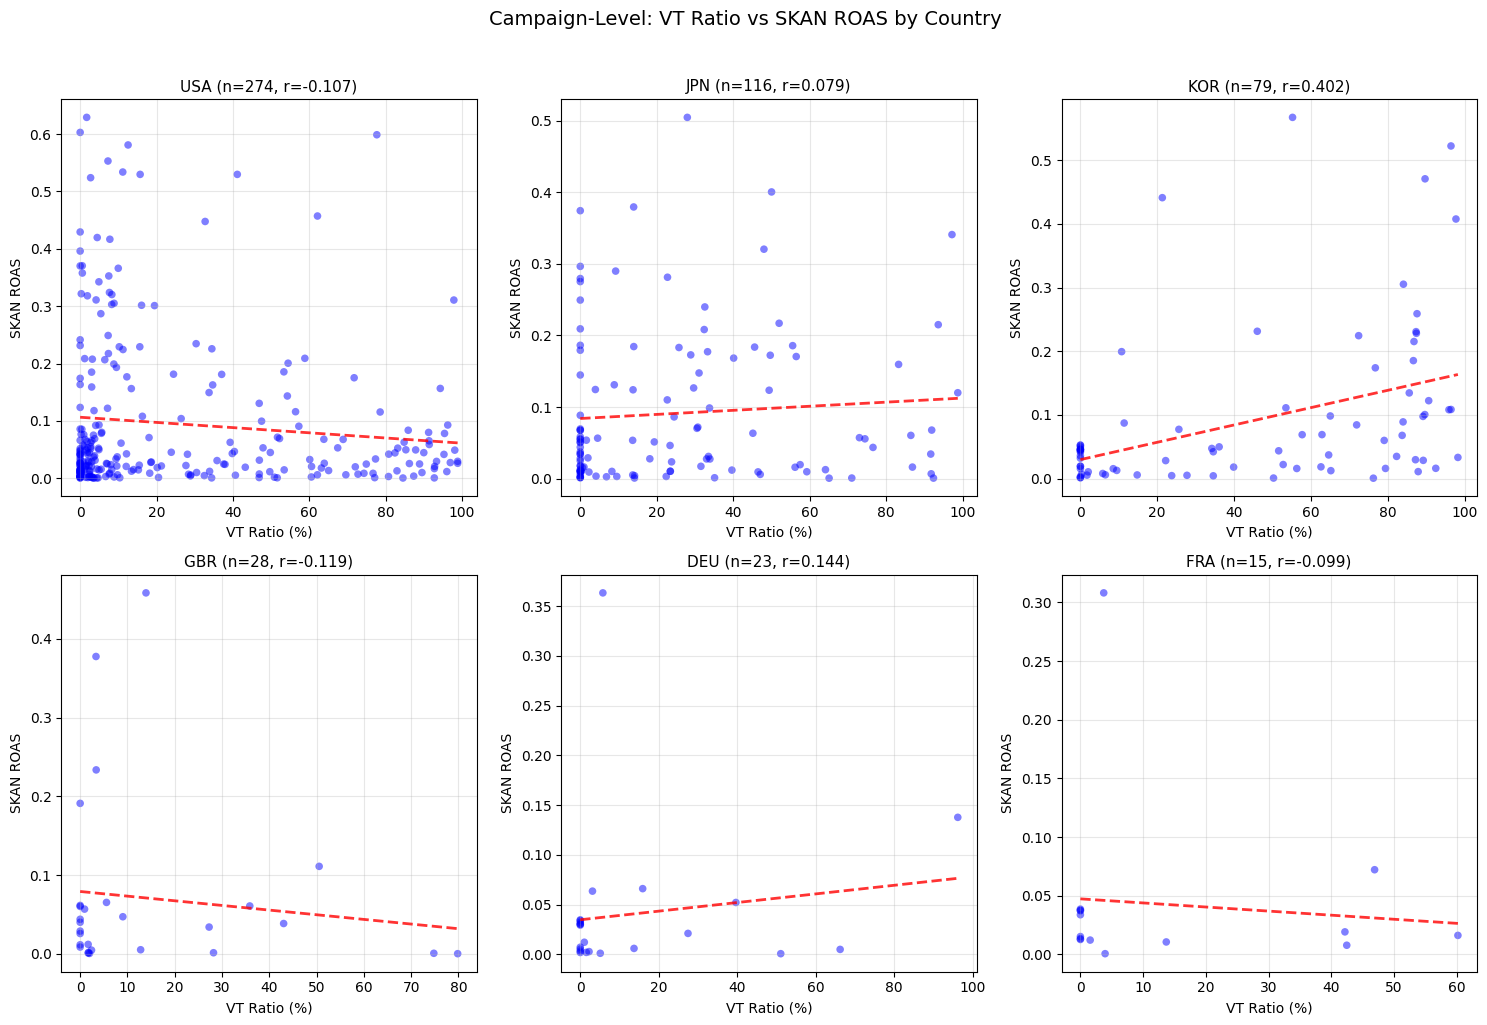

Chart saved as campaign_vt_skan_roas_by_country.png


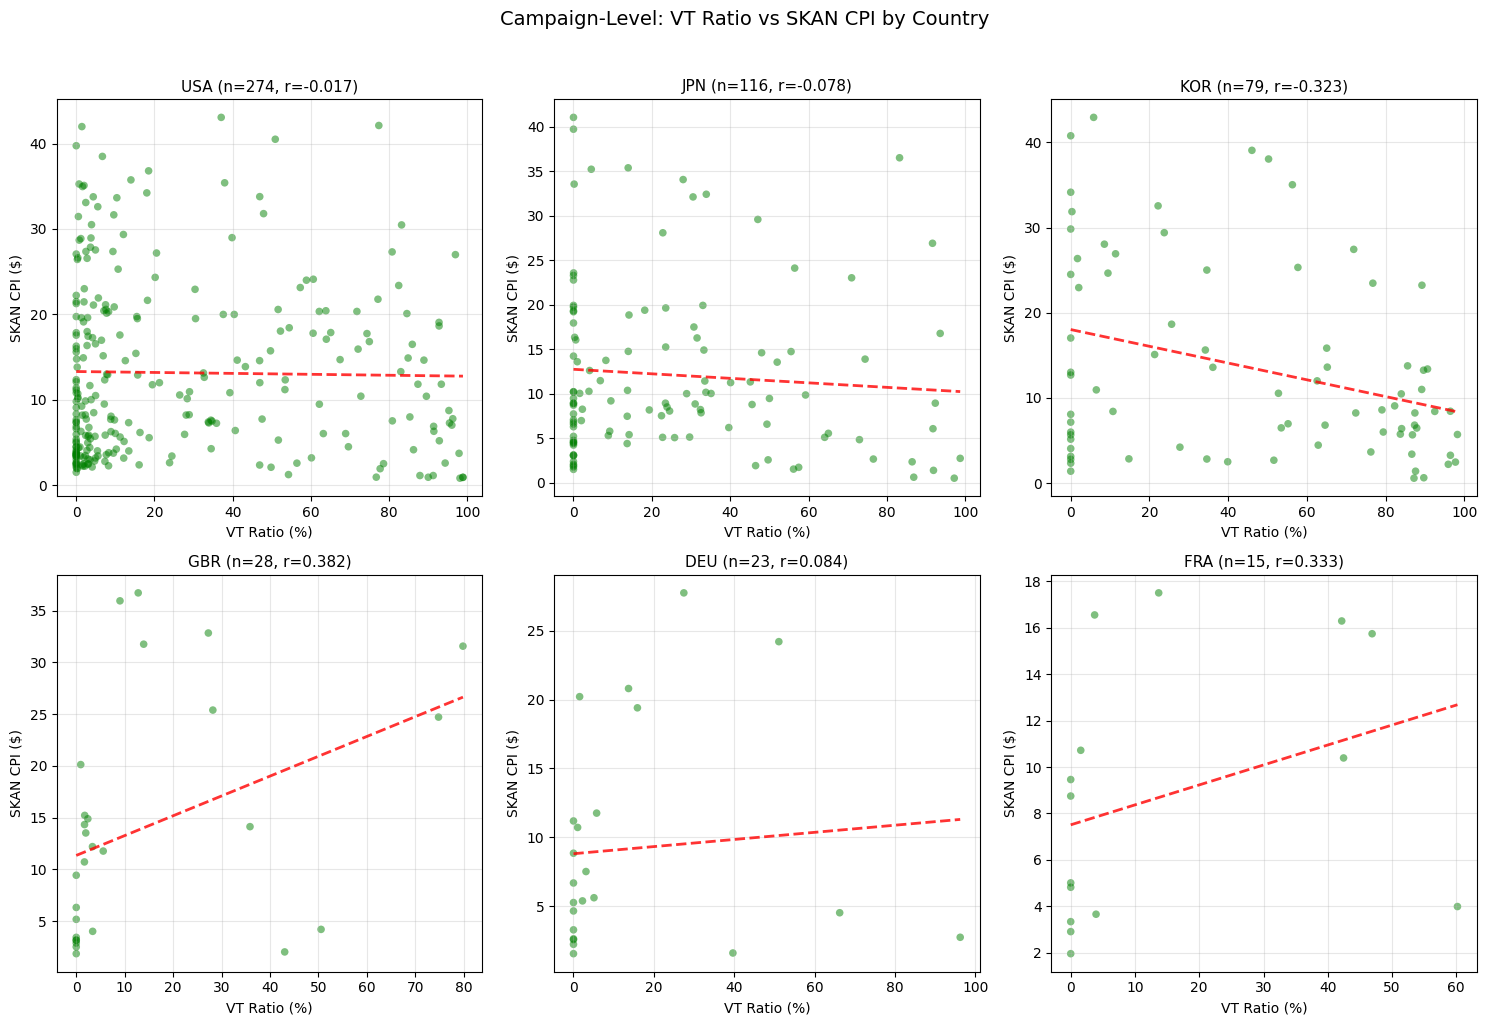

Chart saved as campaign_vt_skan_cpi_by_country.png


In [53]:
#@title Step 6: Visualization - VT vs SKAN Performance by Geo (Campaign-Level)

# Get countries with enough data for visualization
countries_for_plot = df_perf_corr[df_perf_corr['N_Campaigns'] >= 10]['Country'].head(6).tolist()

if len(countries_for_plot) > 0:
    # ===== VT vs SKAN ROAS by Country =====
    fig1, axes1 = plt.subplots(2, 3, figsize=(15, 10))
    axes1 = axes1.flatten()
    
    for idx, country in enumerate(countries_for_plot[:6]):
        country_data = df_perf_clean[df_perf_clean['country'] == country]
        
        if len(country_data) >= 10:
            ax = axes1[idx]
            ax.scatter(country_data['vt_ratio_pct'], country_data['skan_roas'], 
                      alpha=0.5, s=30, c='blue', edgecolors='none')
            
            # Add trend line
            z = np.polyfit(country_data['vt_ratio_pct'], country_data['skan_roas'], 1)
            p = np.poly1d(z)
            x_sorted = country_data['vt_ratio_pct'].sort_values()
            ax.plot(x_sorted, p(x_sorted), 'r--', alpha=0.8, linewidth=2)
            
            corr_row = df_perf_corr[df_perf_corr['Country'] == country]
            corr_val = corr_row['Corr_VT_ROAS'].values[0] if len(corr_row) > 0 else 0
            n_campaigns = len(country_data)
            ax.set_title(f'{country} (n={n_campaigns}, r={corr_val:.3f})', fontsize=11)
            ax.set_xlabel('VT Ratio (%)')
            ax.set_ylabel('SKAN ROAS')
            ax.grid(True, alpha=0.3)
        else:
            axes1[idx].set_visible(False)
    
    for idx in range(len(countries_for_plot), 6):
        axes1[idx].set_visible(False)
    
    plt.suptitle('Campaign-Level: VT Ratio vs SKAN ROAS by Country', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'campaign_vt_skan_roas_by_country.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Chart saved as campaign_vt_skan_roas_by_country.png')
    
    # ===== VT vs SKAN CPI by Country =====
    fig2, axes2 = plt.subplots(2, 3, figsize=(15, 10))
    axes2 = axes2.flatten()
    
    for idx, country in enumerate(countries_for_plot[:6]):
        country_data = df_perf_clean[df_perf_clean['country'] == country]
        
        if len(country_data) >= 10:
            ax = axes2[idx]
            ax.scatter(country_data['vt_ratio_pct'], country_data['skan_cpi'], 
                      alpha=0.5, s=30, c='green', edgecolors='none')
            
            z = np.polyfit(country_data['vt_ratio_pct'], country_data['skan_cpi'], 1)
            p = np.poly1d(z)
            x_sorted = country_data['vt_ratio_pct'].sort_values()
            ax.plot(x_sorted, p(x_sorted), 'r--', alpha=0.8, linewidth=2)
            
            corr_row = df_perf_corr[df_perf_corr['Country'] == country]
            corr_val = corr_row['Corr_VT_CPI'].values[0] if len(corr_row) > 0 else 0
            n_campaigns = len(country_data)
            ax.set_title(f'{country} (n={n_campaigns}, r={corr_val:.3f})', fontsize=11)
            ax.set_xlabel('VT Ratio (%)')
            ax.set_ylabel('SKAN CPI ($)')
            ax.grid(True, alpha=0.3)
        else:
            axes2[idx].set_visible(False)
    
    for idx in range(len(countries_for_plot), 6):
        axes2[idx].set_visible(False)
    
    plt.suptitle('Campaign-Level: VT Ratio vs SKAN CPI by Country', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'campaign_vt_skan_cpi_by_country.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Chart saved as campaign_vt_skan_cpi_by_country.png')
else:
    print('Not enough data for visualization')

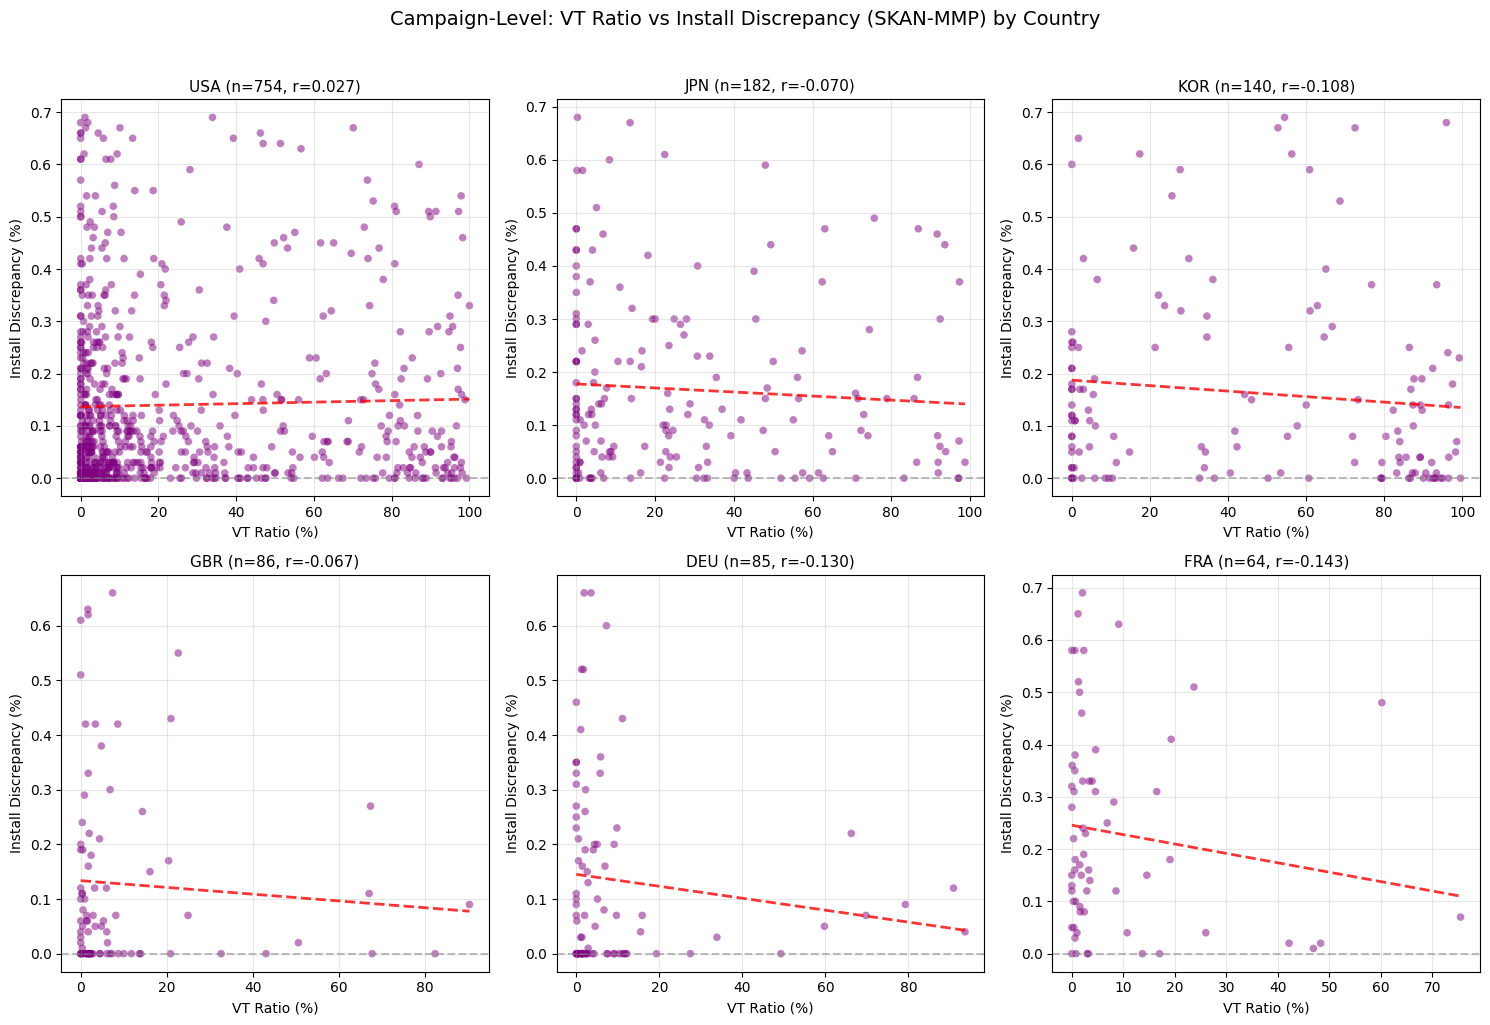

Chart saved as campaign_vt_install_disc_by_country.png


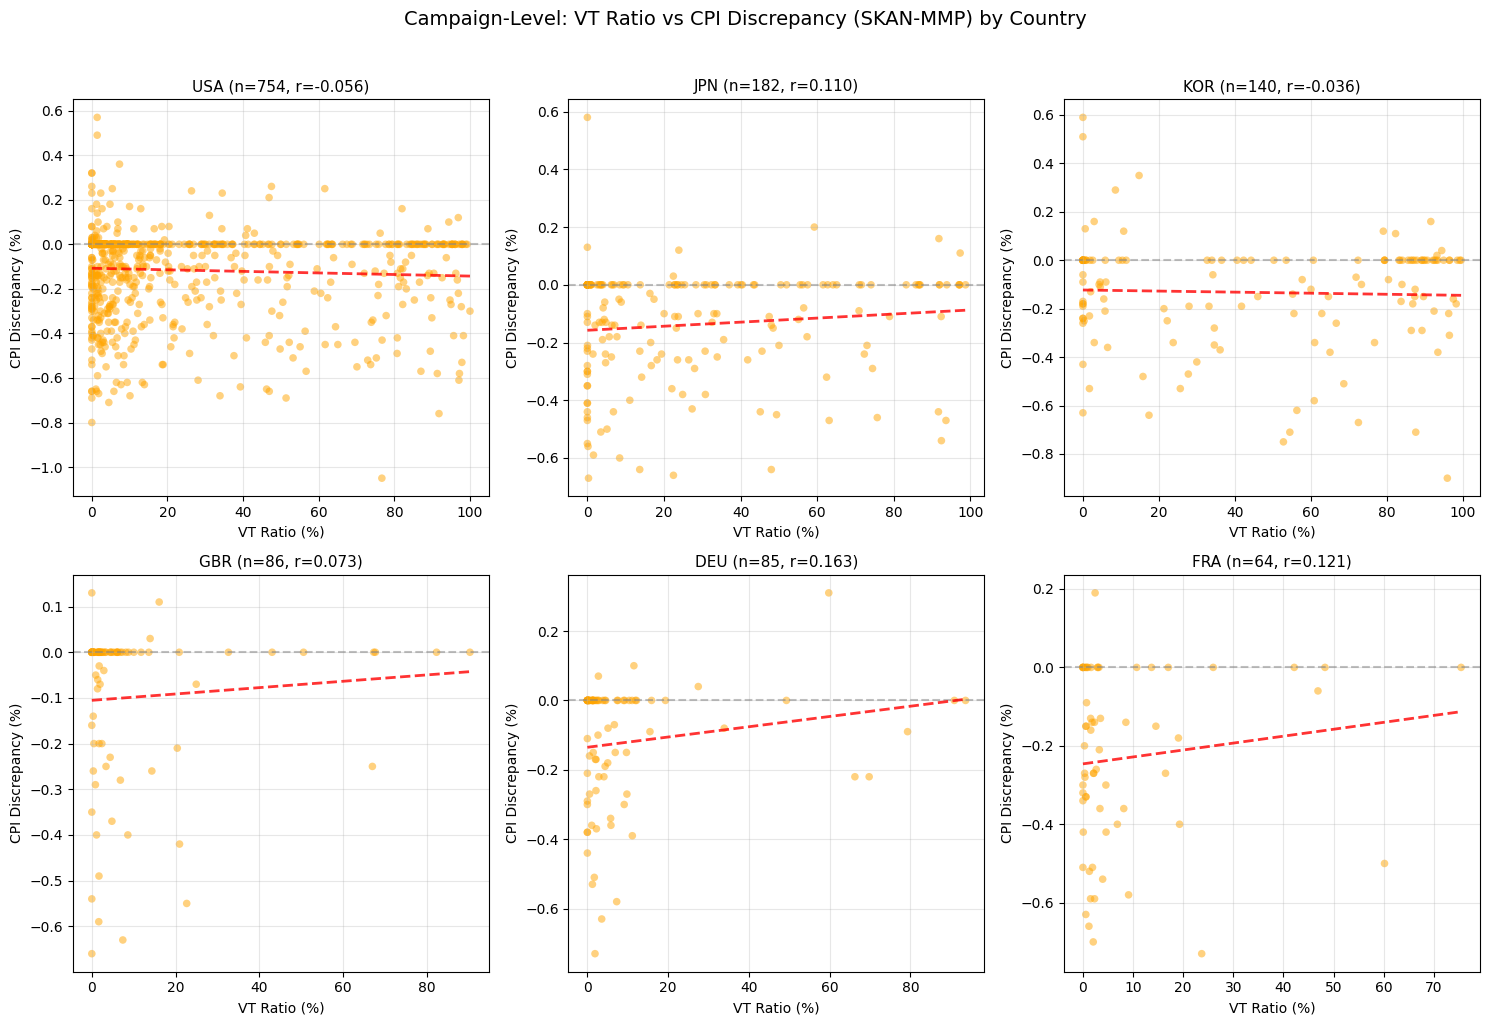

Chart saved as campaign_vt_cpi_disc_by_country.png


In [54]:
#@title Step 7: Visualization - VT vs Discrepancy by Geo (Campaign-Level)

# Get countries with enough data
countries_disc_plot = df_disc_corr[df_disc_corr['N_Campaigns'] >= 10]['Country'].head(6).tolist()

if len(countries_disc_plot) > 0:
    # ===== VT vs Install Discrepancy by Country =====
    fig3, axes3 = plt.subplots(2, 3, figsize=(15, 10))
    axes3 = axes3.flatten()
    
    for idx, country in enumerate(countries_disc_plot[:6]):
        country_data = df_disc_clean[df_disc_clean['country'] == country]
        
        if len(country_data) >= 10:
            ax = axes3[idx]
            ax.scatter(country_data['vt_ratio_pct'], country_data['install_disc_pct'], 
                      alpha=0.5, s=30, c='purple', edgecolors='none')
            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            
            z = np.polyfit(country_data['vt_ratio_pct'], country_data['install_disc_pct'], 1)
            p = np.poly1d(z)
            x_sorted = country_data['vt_ratio_pct'].sort_values()
            ax.plot(x_sorted, p(x_sorted), 'r--', alpha=0.8, linewidth=2)
            
            corr_row = df_disc_corr[df_disc_corr['Country'] == country]
            corr_val = corr_row['Corr_VT_InstDisc'].values[0] if len(corr_row) > 0 and corr_row['Corr_VT_InstDisc'].values[0] else 0
            n_campaigns = len(country_data)
            ax.set_title(f'{country} (n={n_campaigns}, r={corr_val:.3f})', fontsize=11)
            ax.set_xlabel('VT Ratio (%)')
            ax.set_ylabel('Install Discrepancy (%)')
            ax.grid(True, alpha=0.3)
        else:
            axes3[idx].set_visible(False)
    
    for idx in range(len(countries_disc_plot), 6):
        axes3[idx].set_visible(False)
    
    plt.suptitle('Campaign-Level: VT Ratio vs Install Discrepancy (SKAN-MMP) by Country', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'campaign_vt_install_disc_by_country.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Chart saved as campaign_vt_install_disc_by_country.png')
    
    # ===== VT vs CPI Discrepancy by Country =====
    fig4, axes4 = plt.subplots(2, 3, figsize=(15, 10))
    axes4 = axes4.flatten()
    
    for idx, country in enumerate(countries_disc_plot[:6]):
        country_data = df_disc_clean[df_disc_clean['country'] == country]
        
        if len(country_data) >= 10:
            ax = axes4[idx]
            ax.scatter(country_data['vt_ratio_pct'], country_data['cpi_disc_pct'], 
                      alpha=0.5, s=30, c='orange', edgecolors='none')
            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            
            z = np.polyfit(country_data['vt_ratio_pct'], country_data['cpi_disc_pct'], 1)
            p = np.poly1d(z)
            x_sorted = country_data['vt_ratio_pct'].sort_values()
            ax.plot(x_sorted, p(x_sorted), 'r--', alpha=0.8, linewidth=2)
            
            corr_row = df_disc_corr[df_disc_corr['Country'] == country]
            corr_val = corr_row['Corr_VT_CPIDisc'].values[0] if len(corr_row) > 0 and corr_row['Corr_VT_CPIDisc'].values[0] else 0
            n_campaigns = len(country_data)
            ax.set_title(f'{country} (n={n_campaigns}, r={corr_val:.3f})', fontsize=11)
            ax.set_xlabel('VT Ratio (%)')
            ax.set_ylabel('CPI Discrepancy (%)')
            ax.grid(True, alpha=0.3)
        else:
            axes4[idx].set_visible(False)
    
    for idx in range(len(countries_disc_plot), 6):
        axes4[idx].set_visible(False)
    
    plt.suptitle('Campaign-Level: VT Ratio vs CPI Discrepancy (SKAN-MMP) by Country', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'campaign_vt_cpi_disc_by_country.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Chart saved as campaign_vt_cpi_disc_by_country.png')
else:
    print('Not enough data for visualization')

In [55]:
#@title Step 8: Overall Correlation Summary (All Geos Pooled)

print('='*100)
print('OVERALL CORRELATION SUMMARY (All Countries Pooled)')
print('='*100)
print(f'Total campaigns analyzed: {len(df_perf_clean)} (performance), {len(df_disc_clean)} (discrepancy)')

# Overall Performance Correlations
if len(df_perf_clean) > 10:
    corr_vt_roas_all, p_vt_roas_all = stats.pearsonr(df_perf_clean['vt_ratio_pct'], df_perf_clean['skan_roas'])
    corr_vt_cpi_all, p_vt_cpi_all = stats.pearsonr(df_perf_clean['vt_ratio_pct'], df_perf_clean['skan_cpi'])
    
    print('\n[VT vs SKAN Performance - All Campaigns]')
    print(f'  VT vs SKAN ROAS: r={corr_vt_roas_all:.4f} (p={p_vt_roas_all:.4f}) {"*" if p_vt_roas_all < 0.05 else ""}')
    print(f'  VT vs SKAN CPI:  r={corr_vt_cpi_all:.4f} (p={p_vt_cpi_all:.4f}) {"*" if p_vt_cpi_all < 0.05 else ""}')

# Overall Discrepancy Correlations
if len(df_disc_clean) > 10:
    corr_vt_inst_all, p_vt_inst_all = stats.pearsonr(df_disc_clean['vt_ratio_pct'], df_disc_clean['install_disc_pct'])
    corr_vt_cpi_disc_all, p_vt_cpi_disc_all = stats.pearsonr(df_disc_clean['vt_ratio_pct'], df_disc_clean['cpi_disc_pct'])
    
    print('\n[VT vs MMP-SKAN Discrepancy - All Campaigns]')
    print(f'  VT vs Install Disc: r={corr_vt_inst_all:.4f} (p={p_vt_inst_all:.4f}) {"*" if p_vt_inst_all < 0.05 else ""}')
    print(f'  VT vs CPI Disc:     r={corr_vt_cpi_disc_all:.4f} (p={p_vt_cpi_disc_all:.4f}) {"*" if p_vt_cpi_disc_all < 0.05 else ""}')

print('\n' + '-'*100)
print('* = statistically significant (p < 0.05)')

# Combined results table
print('\n' + '='*100)
print('COMBINED CORRELATION RESULTS BY GEO')
print('='*100)

# Merge performance and discrepancy correlations
df_combined = df_perf_corr[['Country', 'N_Campaigns', 'Avg_VT_Ratio', 'Corr_VT_ROAS', 'Sig_ROAS', 'Corr_VT_CPI', 'Sig_CPI']].copy()
df_disc_subset = df_disc_corr[['Country', 'Corr_VT_InstDisc', 'Sig_Inst', 'Corr_VT_CPIDisc', 'Sig_CPI']].copy()
df_disc_subset.columns = ['Country', 'Corr_VT_InstDisc', 'Sig_InstDisc', 'Corr_VT_CPIDisc', 'Sig_CPIDisc']
df_combined = df_combined.merge(df_disc_subset, on='Country', how='left')

print(df_combined.to_string(index=False))

OVERALL CORRELATION SUMMARY (All Countries Pooled)
Total campaigns analyzed: 606 (performance), 1494 (discrepancy)

[VT vs SKAN Performance - All Campaigns]
  VT vs SKAN ROAS: r=0.0489 (p=0.2291) 
  VT vs SKAN CPI:  r=-0.0361 (p=0.3748) 

[VT vs MMP-SKAN Discrepancy - All Campaigns]
  VT vs Install Disc: r=-0.0422 (p=0.1031) 
  VT vs CPI Disc:     r=0.0144 (p=0.5784) 

----------------------------------------------------------------------------------------------------
* = statistically significant (p < 0.05)

COMBINED CORRELATION RESULTS BY GEO
Country  N_Campaigns  Avg_VT_Ratio  Corr_VT_ROAS Sig_ROAS  Corr_VT_CPI Sig_CPI  Corr_VT_InstDisc Sig_InstDisc  Corr_VT_CPIDisc Sig_CPIDisc
    USA          274          25.9       -0.1068               -0.0170                    0.0268                       -0.0556            
    JPN          116          26.1        0.0786               -0.0784                   -0.0703                        0.1103            
    KOR           79          45

In [56]:
#@title Step 9: VT Bucket Analysis (Campaign-Level)

# Create VT ratio buckets
df_perf_clean['vt_bucket'] = pd.cut(
    df_perf_clean['vt_ratio_pct'], 
    bins=[0, 20, 40, 60, 80, 100],
    labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
)

print('='*100)
print('SKAN PERFORMANCE BY VT RATIO BUCKET (Campaign-Level)')
print('='*100)

# Overall bucket summary
bucket_summary = df_perf_clean.groupby('vt_bucket').agg({
    'campaign_id': 'count',
    'bundle': 'nunique',
    'vt_ratio_pct': 'mean',
    'skan_roas': 'mean',
    'skan_cpi': 'mean',
    'mmp_spend': 'sum'
}).round(4)

bucket_summary.columns = ['N_Campaigns', 'N_Bundles', 'Avg_VT_Ratio', 'Avg_SKAN_ROAS', 'Avg_SKAN_CPI', 'Total_Spend']
bucket_summary['Total_Spend'] = bucket_summary['Total_Spend'].apply(lambda x: f'${x:,.0f}')

print('\n[OVERALL - All Countries]')
print(bucket_summary)

# By country bucket summary
print('\n' + '-'*100)
print('\n[BY COUNTRY - SKAN ROAS by VT Bucket]')

for country in TARGET_COUNTRIES[:5]:
    c_data = df_perf_clean[df_perf_clean['country'] == country]
    if len(c_data) >= 20:
        c_bucket = c_data.groupby('vt_bucket').agg({
            'campaign_id': 'count',
            'skan_roas': 'mean',
            'skan_cpi': 'mean'
        }).round(4)
        c_bucket.columns = ['N', 'SKAN_ROAS', 'SKAN_CPI']
        print(f'\n  {country}:')
        print(c_bucket.to_string().replace('\n', '\n    '))

SKAN PERFORMANCE BY VT RATIO BUCKET (Campaign-Level)

[OVERALL - All Countries]
           N_Campaigns  N_Bundles  Avg_VT_Ratio  Avg_SKAN_ROAS  Avg_SKAN_CPI  \
vt_bucket                                                                      
0-20%              206        121        5.9990         0.1076       14.9075   
20-40%              76         57       30.3325         0.0822       15.6239   
40-60%              61         44       49.4718         0.0957       15.2030   
60-80%              49         35       69.7657         0.0802       12.4533   
80-100%             75         37       90.2797         0.1068        9.1896   

           Total_Spend  
vt_bucket               
0-20%      $23,777,807  
20-40%      $6,876,318  
40-60%      $5,514,690  
60-80%      $4,409,361  
80-100%     $6,048,574  

----------------------------------------------------------------------------------------------------

[BY COUNTRY - SKAN ROAS by VT Bucket]

  USA:
             N  SKAN_ROAS  SKAN_CPI

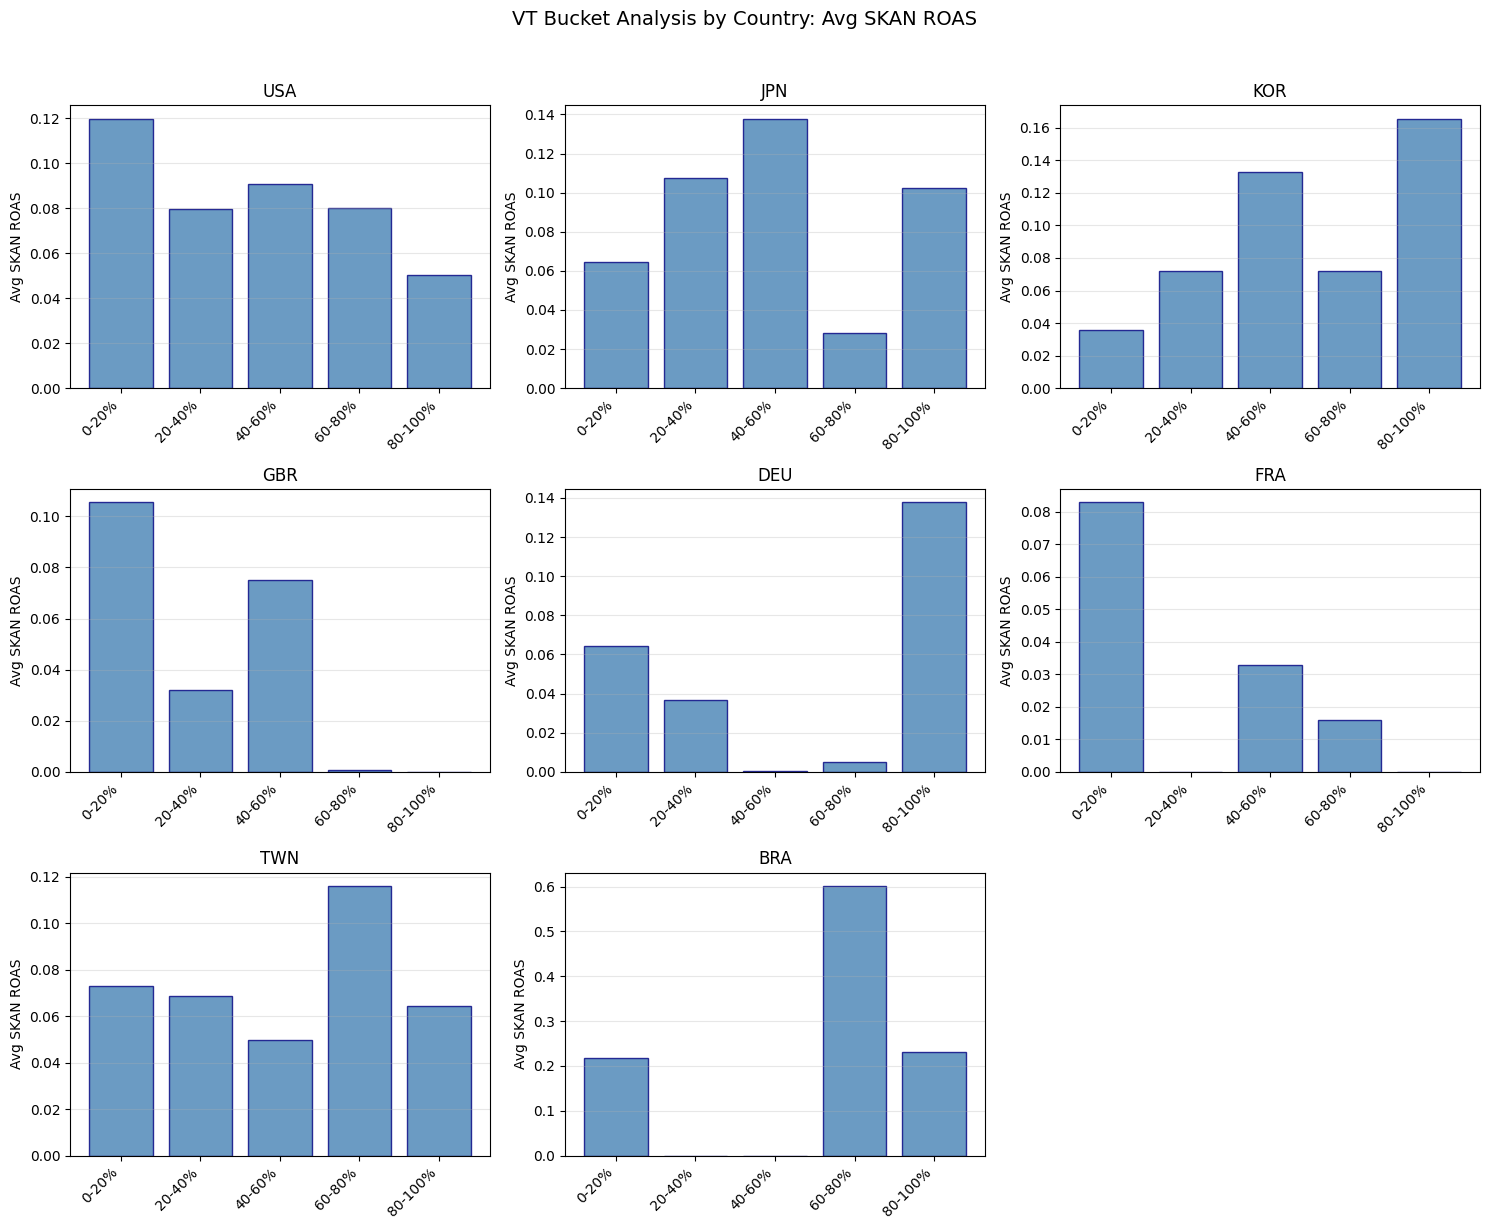

Saved: vt_bucket_skan_roas_by_country.png


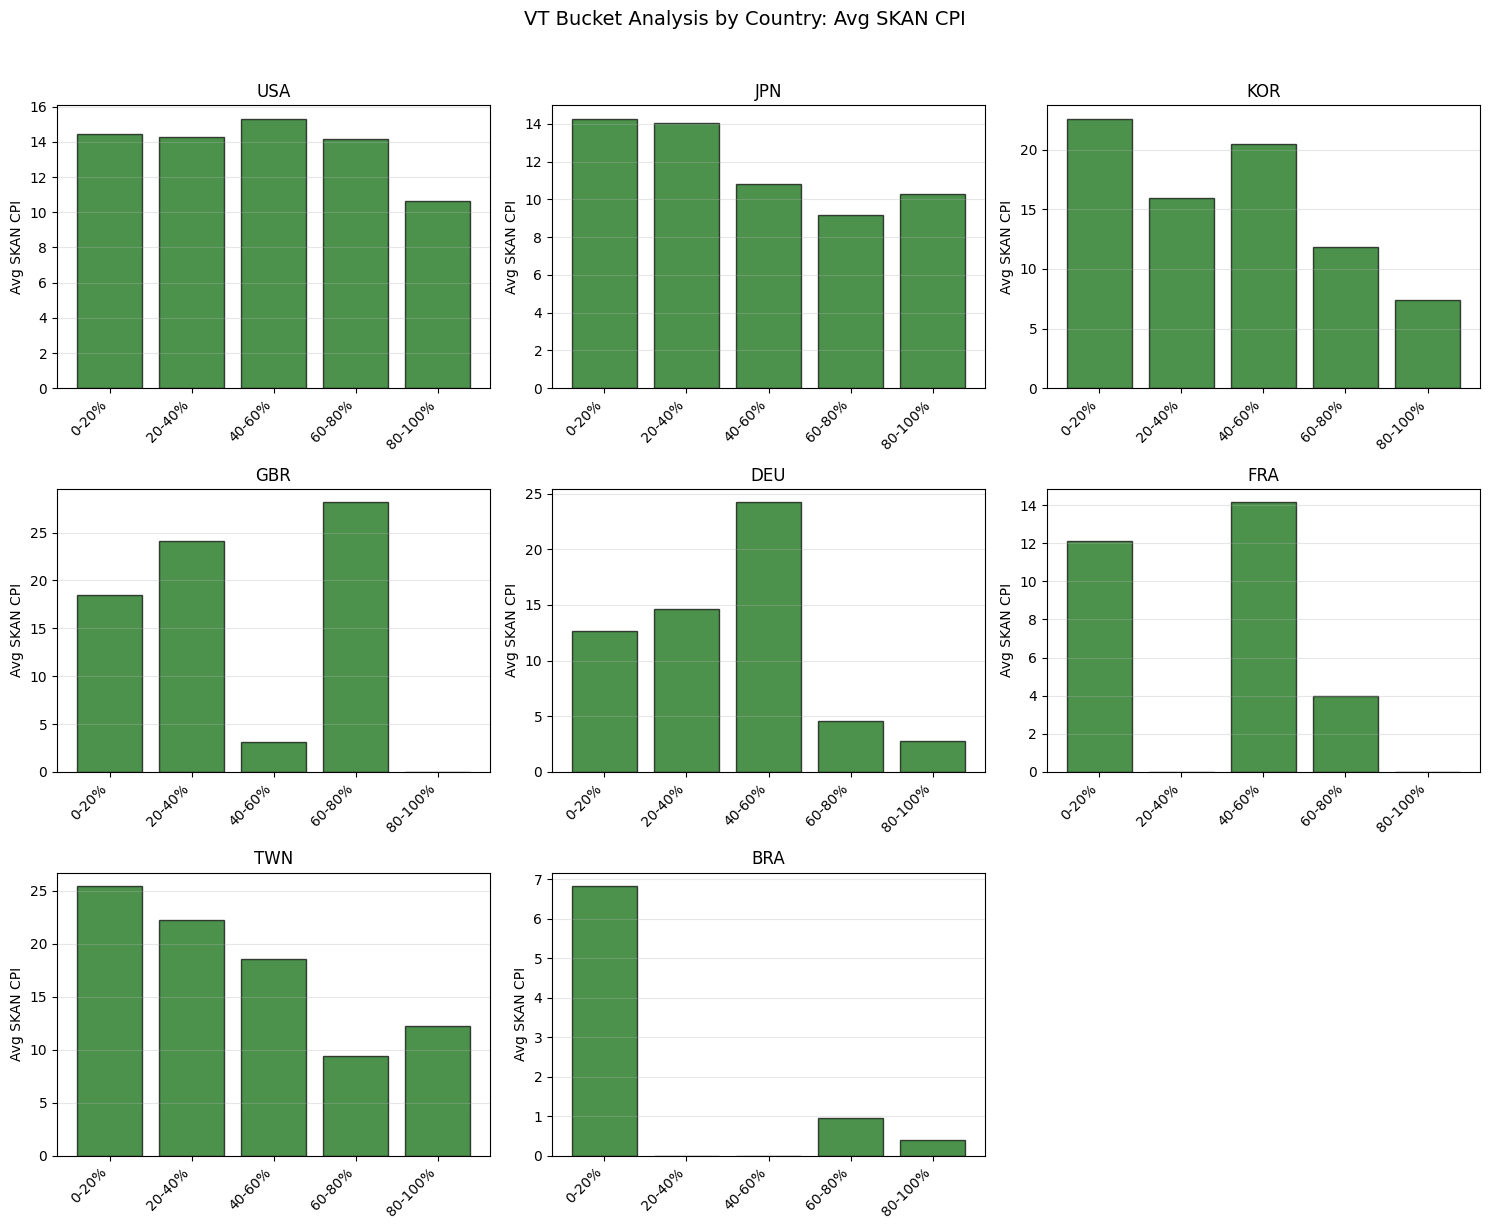

Saved: vt_bucket_skan_cpi_by_country.png


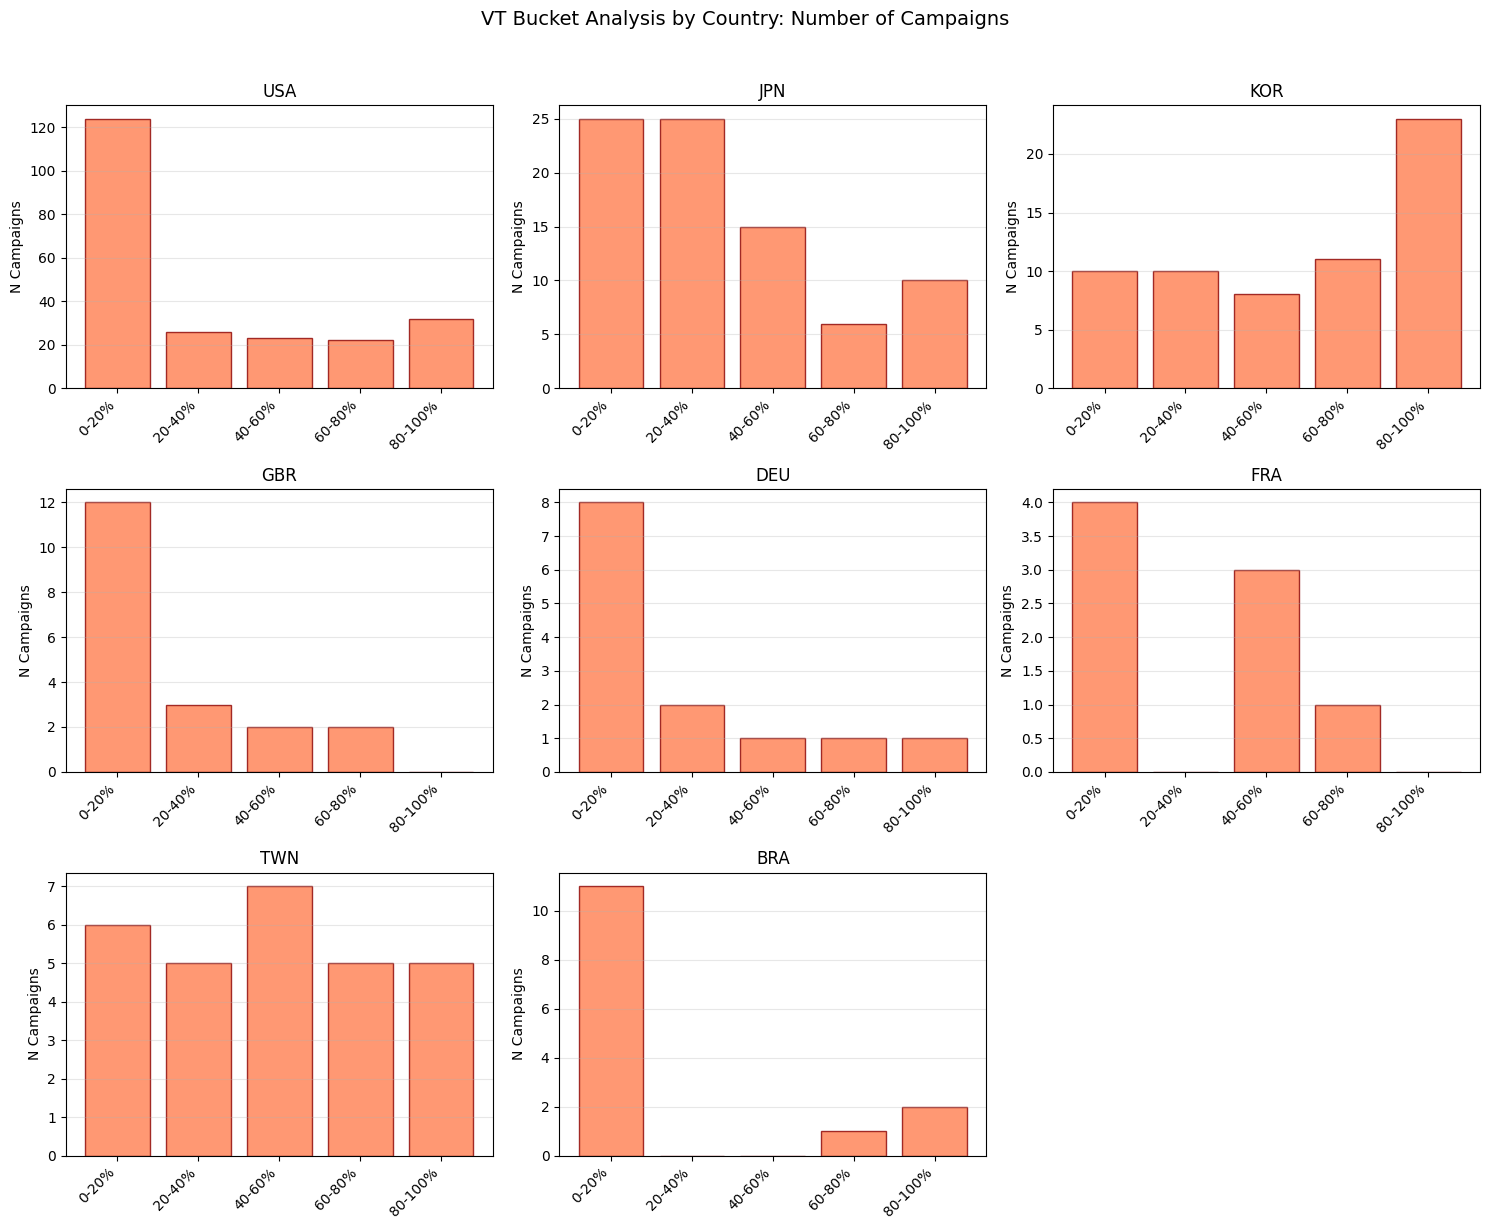

Saved: vt_bucket_n_campaigns_by_country.png


In [57]:
#@title Step 9b: Visualize VT Bucket Analysis by Country

# Build country x VT bucket summary for plotting
bucket_by_country = df_perf_clean.groupby(['country', 'vt_bucket']).agg({
    'campaign_id': 'count',
    'skan_roas': 'mean',
    'skan_cpi': 'mean'
}).reset_index()
bucket_by_country.columns = ['country', 'vt_bucket', 'n_campaigns', 'skan_roas', 'skan_cpi']

# Countries with enough campaigns for at least 3 VT buckets
min_campaigns_per_country = 15
countries_with_data = [c for c in TARGET_COUNTRIES 
                       if len(df_perf_clean[df_perf_clean['country'] == c]) >= min_campaigns_per_country]
bucket_order = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']

# --- Figure 1: SKAN ROAS by VT bucket by country (line chart) ---
n_countries = len(countries_with_data)
min_n_per_bucket_warn = 5  # flag buckets with n < this for caution
if n_countries > 0:
    n_cols = 3
    n_rows = (n_countries + n_cols - 1) // n_cols
    fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes1 = np.atleast_2d(axes1)
    for idx, country in enumerate(countries_with_data):
        row, col = idx // n_cols, idx % n_cols
        ax = axes1[row, col]
        data = bucket_by_country[bucket_by_country['country'] == country].set_index('vt_bucket').reindex(bucket_order)
        x = range(len(bucket_order))
        roas_vals = data['skan_roas'].values
        roas_vals = np.where(np.isfinite(roas_vals), roas_vals, np.nan)
        n_vals = data['n_campaigns'].fillna(0).values.astype(int)
        ax.plot(x, roas_vals, marker='o', linestyle='-', color='steelblue', linewidth=2, markersize=8)
        for i, (xv, n) in enumerate(zip(x, n_vals)):
            if n > 0 and np.isfinite(roas_vals[i]): ax.annotate(f'n={int(n)}', (xv, roas_vals[i]), textcoords='offset points', xytext=(0, 8), ha='center', fontsize=7, color='gray' if n < min_n_per_bucket_warn else 'black')
        ax.set_xticks(x)
        ax.set_xticklabels(bucket_order, rotation=45, ha='right')
        ax.set_ylabel('Avg SKAN ROAS')
        ax.set_title(f'{country}')
        ax.grid(True, alpha=0.3, axis='y')
    for idx in range(n_countries, n_rows * n_cols):
        row, col = idx // n_cols, idx % n_cols
        axes1[row, col].set_visible(False)
    plt.suptitle('VT Bucket Analysis by Country: Avg SKAN ROAS (line)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'vt_bucket_skan_roas_by_country.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: vt_bucket_skan_roas_by_country.png')

    # --- Figure 2: SKAN CPI by VT bucket by country (line chart) ---
    fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes2 = np.atleast_2d(axes2)
    for idx, country in enumerate(countries_with_data):
        row, col = idx // n_cols, idx % n_cols
        ax = axes2[row, col]
        data = bucket_by_country[bucket_by_country['country'] == country].set_index('vt_bucket').reindex(bucket_order)
        x = range(len(bucket_order))
        cpi_vals = data['skan_cpi'].values
        cpi_vals = np.where(np.isfinite(cpi_vals), cpi_vals, np.nan)
        n_vals = data['n_campaigns'].fillna(0).values.astype(int)
        ax.plot(x, cpi_vals, marker='s', linestyle='-', color='darkgreen', linewidth=2, markersize=8)
        for i, (xv, n) in enumerate(zip(x, n_vals)):
            if n > 0 and np.isfinite(cpi_vals[i]): ax.annotate(f'n={int(n)}', (xv, cpi_vals[i]), textcoords='offset points', xytext=(0, 8), ha='center', fontsize=7, color='gray' if n < min_n_per_bucket_warn else 'black')
        ax.set_xticks(x)
        ax.set_xticklabels(bucket_order, rotation=45, ha='right')
        ax.set_ylabel('Avg SKAN CPI')
        ax.set_title(f'{country}')
        ax.grid(True, alpha=0.3, axis='y')
    for idx in range(n_countries, n_rows * n_cols):
        row, col = idx // n_cols, idx % n_cols
        axes2[row, col].set_visible(False)
    plt.suptitle('VT Bucket Analysis by Country: Avg SKAN CPI (line)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'vt_bucket_skan_cpi_by_country.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: vt_bucket_skan_cpi_by_country.png')

    # --- Figure 3: Campaign count by VT bucket by country (line chart) ---
    fig3, axes3 = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes3 = np.atleast_2d(axes3)
    for idx, country in enumerate(countries_with_data):
        row, col = idx // n_cols, idx % n_cols
        ax = axes3[row, col]
        data = bucket_by_country[bucket_by_country['country'] == country].set_index('vt_bucket').reindex(bucket_order)
        x = range(len(bucket_order))
        n_vals = data['n_campaigns'].fillna(0).values.astype(int)
        ax.plot(x, n_vals, marker='^', linestyle='-', color='coral', linewidth=2, markersize=8)
        ax.set_xticks(x)
        ax.set_xticklabels(bucket_order, rotation=45, ha='right')
        ax.set_ylabel('N Campaigns')
        ax.set_title(f'{country}')
        ax.grid(True, alpha=0.3, axis='y')
    for idx in range(n_countries, n_rows * n_cols):
        row, col = idx // n_cols, idx % n_cols
        axes3[row, col].set_visible(False)
    plt.suptitle('VT Bucket Analysis by Country: Number of Campaigns (line)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'vt_bucket_n_campaigns_by_country.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: vt_bucket_n_campaigns_by_country.png')

    # --- Quick interpretations (sample size & statistical significance) ---
    print('\n' + '='*80)
    print('QUICK INTERPRETATIONS (VT Bucket by Country)')
    print('='*80)
    for country in countries_with_data:
        c_data = bucket_by_country[bucket_by_country['country'] == country]
        n_total = c_data['n_campaigns'].sum()
        n_buckets_with_low_n = (c_data['n_campaigns'] < min_n_per_bucket_warn).sum()
        roas_vals = c_data.set_index('vt_bucket').reindex(bucket_order)['skan_roas'].values
        roas_vals = roas_vals[np.isfinite(roas_vals)]
        if len(roas_vals) >= 3:
            r_trend, p_trend = stats.spearmanr(range(len(roas_vals)), roas_vals)
            sig = 'significant' if p_trend < 0.05 else 'not significant'
        else:
            r_trend, p_trend, sig = np.nan, np.nan, 'N/A (too few buckets)'
        print(f"\n  {country}: N={int(n_total)} campaigns across buckets. " +
              (f"{int(n_buckets_with_low_n)} bucket(s) have n<{min_n_per_bucket_warn} (interpret with caution). " if n_buckets_with_low_n > 0 else "All buckets have n>=%d. " % min_n_per_bucket_warn) +
              (f"ROAS trend across VT buckets: r={r_trend:.3f}, p={p_trend:.3f} ({sig})." if isinstance(sig, str) and 'N/A' not in sig else f"ROAS trend: {sig}"))
    print('\n  General caveats:')
    print('  - Points labeled with n<5 are low-sample; means can be unstable and not statistically reliable.')
    print('  - "Significant" trend (p<0.05) means the rank correlation (Spearman) of ROAS vs VT bucket is unlikely due to chance.')
    print('  - Line charts show pattern across buckets; avoid over-interpreting single buckets with small n.')
else:
    print('No country has enough campaigns (min 15) for VT bucket visualization.')

In [58]:
#@title Step 10: High VT Campaigns Detail

print('='*100)
print('HIGH VT CAMPAIGNS (VT Ratio >= 50%)')
print('='*100)

# Filter high VT campaigns
high_vt = df_valid[df_valid['vt_ratio_pct'] >= 50].sort_values('mmp_spend', ascending=False)

print(f'Total high VT campaigns: {len(high_vt)}')
print(f'Countries: {high_vt["country"].nunique()}')
print(f'Bundles: {high_vt["bundle"].nunique()}')

# Summary by country
print('\n[High VT Campaigns by Country]')
high_vt_summary = high_vt.groupby('country').agg({
    'campaign_id': 'count',
    'bundle': 'nunique',
    'mmp_spend': 'sum',
    'vt_ratio_pct': 'mean',
    'skan_roas': 'mean',
    'skan_cpi': 'mean'
}).round(2)
high_vt_summary.columns = ['N_Campaigns', 'N_Bundles', 'Total_Spend', 'Avg_VT', 'Avg_SKAN_ROAS', 'Avg_SKAN_CPI']
high_vt_summary = high_vt_summary.sort_values('Total_Spend', ascending=False)
print(high_vt_summary)

# Top high VT campaigns
print('\n' + '-'*100)
print('\n[Top 20 High VT Campaigns by Spend]')
display_cols = ['country', 'app_name', 'campaign_goal', 'mmp_spend', 'vt_ratio_pct', 
                'skan_roas', 'skan_cpi', 'cpi_disc_pct']
print(high_vt[[c for c in display_cols if c in high_vt.columns]].head(20).to_string(index=False))

HIGH VT CAMPAIGNS (VT Ratio >= 50%)
Total high VT campaigns: 441
Countries: 10
Bundles: 222

[High VT Campaigns by Country]
         N_Campaigns  N_Bundles  Total_Spend  Avg_VT  Avg_SKAN_ROAS  \
country                                                               
USA              187        118  15236361.14   78.45          15.56   
KOR              104         65   7477806.83   80.42           0.17   
JPN               65         49   4192011.37   77.05           1.48   
TWN               38         24   1933955.20   78.06       40161.05   
GBR               12          8   1118144.68   77.05           0.04   
CAN               12         10    680810.35   73.35         131.75   
BRA                4          2    381505.34   78.00         228.13   
DEU               11          9    311145.86   81.38           0.05   
FRA                4          4     73518.14   69.69           0.02   
AUS                4          4     60845.92   77.80            NaN   

         Avg_SKAN_CPI  

In [59]:
#@title Step 11: Export to Excel

import re
# Remove Excel-illegal control characters (openpyxl rejects 0x00-0x08, 0x0b, 0x0c, 0x0e-0x1f, 0x7f-0x9f)
_excel_illegal_re = re.compile(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\x9f]')
def _sanitize_for_excel(df):
    if df is None or (isinstance(df, pd.DataFrame) and df.empty): return df
    out = df.copy()
    for col in out.select_dtypes(include=[object]).columns:
        out[col] = out[col].astype(str).str.replace(_excel_illegal_re, '', regex=True)
    return out

output_file = OUTPUT_DIR / 'Campaign_VT_vs_SKAN_Analysis.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Sheet 1: All Campaign Data
    _sanitize_for_excel(df_valid).to_excel(writer, sheet_name='All_Campaigns', index=False)
    
    # Sheet 2: Performance Correlation by Geo
    _sanitize_for_excel(df_perf_corr).to_excel(writer, sheet_name='Perf_Corr_by_Geo', index=False)
    
    # Sheet 3: Discrepancy Correlation by Geo
    _sanitize_for_excel(df_disc_corr).to_excel(writer, sheet_name='Disc_Corr_by_Geo', index=False)
    
    # Sheet 4: Combined Correlation Results
    _sanitize_for_excel(df_combined).to_excel(writer, sheet_name='Combined_Results', index=False)
    
    # Sheet 5: VT Bucket Summary
    (_sanitize_for_excel(bucket_summary) if isinstance(bucket_summary, pd.DataFrame) else bucket_summary).to_excel(writer, sheet_name='VT_Bucket_Summary')
    
    # Sheet 6: High VT Campaigns
    _sanitize_for_excel(high_vt).to_excel(writer, sheet_name='High_VT_Campaigns', index=False)
    
    # Sheet 7: Country Summary
    (_sanitize_for_excel(country_summary) if isinstance(country_summary, pd.DataFrame) else country_summary).to_excel(writer, sheet_name='Country_Summary')
    
    # Sheet 8: Overall Correlation Summary
    overall_corr = pd.DataFrame({
        'Metric': [
            'VT vs SKAN ROAS (Performance)',
            'VT vs SKAN CPI (Performance)',
            'VT vs Install Discrepancy',
            'VT vs CPI Discrepancy'
        ],
        'Correlation (r)': [
            corr_vt_roas_all if 'corr_vt_roas_all' in dir() else None,
            corr_vt_cpi_all if 'corr_vt_cpi_all' in dir() else None,
            corr_vt_inst_all if 'corr_vt_inst_all' in dir() else None,
            corr_vt_cpi_disc_all if 'corr_vt_cpi_disc_all' in dir() else None
        ],
        'P-value': [
            p_vt_roas_all if 'p_vt_roas_all' in dir() else None,
            p_vt_cpi_all if 'p_vt_cpi_all' in dir() else None,
            p_vt_inst_all if 'p_vt_inst_all' in dir() else None,
            p_vt_cpi_disc_all if 'p_vt_cpi_disc_all' in dir() else None
        ]
    })
    _sanitize_for_excel(overall_corr).to_excel(writer, sheet_name='Overall_Correlation', index=False)

print(f'Data exported to {output_file}')
print('\nSheets:')
print('  1. All_Campaigns - All campaign data with metrics')
print('  2. Perf_Corr_by_Geo - VT vs SKAN Performance correlations by country')
print('  3. Disc_Corr_by_Geo - VT vs Discrepancy correlations by country')
print('  4. Combined_Results - Combined correlation table')
print('  5. VT_Bucket_Summary - SKAN performance by VT ratio bucket')
print('  6. High_VT_Campaigns - Campaigns with VT >= 50%')
print('  7. Country_Summary - Summary statistics by country')
print('  8. Overall_Correlation - Overall correlation summary')

Data exported to Campaign_VT_vs_SKAN_Analysis.xlsx

Sheets:
  1. All_Campaigns - All campaign data with metrics
  2. Perf_Corr_by_Geo - VT vs SKAN Performance correlations by country
  3. Disc_Corr_by_Geo - VT vs Discrepancy correlations by country
  4. Combined_Results - Combined correlation table
  5. VT_Bucket_Summary - SKAN performance by VT ratio bucket
  6. High_VT_Campaigns - Campaigns with VT >= 50%
  7. Country_Summary - Summary statistics by country
  8. Overall_Correlation - Overall correlation summary


In [60]:
#@title Step 12: Analysis Summary & Key Findings

print('='*100)
print('CAMPAIGN-LEVEL VT vs SKAN ANALYSIS - SUMMARY')
print('='*100)

print(f'''
DATASET:
  - Platform: iOS Gaming (product.is_gaming = TRUE)
  - Lookback: {LOOKBACK_MONTHS} months
  - Unit of Analysis: Individual Campaign (single-geo only)
  - Total Campaigns: {len(df_valid)}
  - Countries: {df_valid['country'].nunique()}
  - Bundles: {df_valid['bundle'].nunique()}

PART 1: VT RATIO vs SKAN PERFORMANCE
  Question: Does higher VT ratio correlate with better/worse SKAN metrics?
  
  Overall (All Countries Pooled):
    - VT vs SKAN ROAS: r={corr_vt_roas_all:.4f} {'(significant)' if p_vt_roas_all < 0.05 else '(not significant)'}
    - VT vs SKAN CPI:  r={corr_vt_cpi_all:.4f} {'(significant)' if p_vt_cpi_all < 0.05 else '(not significant)'}

PART 2: VT RATIO vs MMP-SKAN DISCREPANCY
  Question: Does higher VT ratio correlate with larger MMP-SKAN gaps?
  
  Overall (All Countries Pooled):
    - VT vs Install Disc: r={corr_vt_inst_all:.4f} {'(significant)' if p_vt_inst_all < 0.05 else '(not significant)'}
    - VT vs CPI Disc:     r={corr_vt_cpi_disc_all:.4f} {'(significant)' if p_vt_cpi_disc_all < 0.05 else '(not significant)'}
''')

print('='*100)
print('KEY FINDINGS BY GEO:')
print('='*100)

# Summarize findings by geo
for _, row in df_combined.iterrows():
    country = row['Country']
    n = row['N_Campaigns']
    if n >= 10:
        findings = []
        if row['Corr_VT_ROAS'] is not None:
            if row['Sig_ROAS'] == '*':
                direction = 'higher' if row['Corr_VT_ROAS'] > 0 else 'lower'
                findings.append(f"Higher VT → {direction} SKAN ROAS")
        if 'Corr_VT_CPIDisc' in row and row['Corr_VT_CPIDisc'] is not None:
            if row['Sig_CPIDisc'] == '*':
                direction = 'larger' if row['Corr_VT_CPIDisc'] > 0 else 'smaller'
                findings.append(f"Higher VT → {direction} CPI gap")
        
        if findings:
            print(f"  {country} (n={n}): {'; '.join(findings)}")
        else:
            print(f"  {country} (n={n}): No significant correlations")

print('\n' + '='*100)
print('INTERPRETATION:')
print('='*100)
print('''
  - Weak correlations (|r| < 0.3): VT ratio has minimal impact on SKAN metrics
  - Moderate correlations (0.3 < |r| < 0.5): VT ratio has some influence
  - Strong correlations (|r| > 0.5): VT ratio significantly affects SKAN metrics
  
  If VT-ROAS correlation is NEGATIVE: High VT campaigns show worse SKAN ROAS
  If VT-ROAS correlation is POSITIVE: High VT campaigns show better SKAN ROAS
  
  If VT-Discrepancy correlation is POSITIVE: High VT → SKAN overstates vs MMP
  If VT-Discrepancy correlation is NEGATIVE: High VT → SKAN understates vs MMP
''')

CAMPAIGN-LEVEL VT vs SKAN ANALYSIS - SUMMARY

DATASET:
  - Platform: iOS Gaming (product.is_gaming = TRUE)
  - Lookback: 6 months
  - Unit of Analysis: Individual Campaign (single-geo only)
  - Total Campaigns: 2000
  - Countries: 10
  - Bundles: 750

PART 1: VT RATIO vs SKAN PERFORMANCE
  Question: Does higher VT ratio correlate with better/worse SKAN metrics?

  Overall (All Countries Pooled):
    - VT vs SKAN ROAS: r=0.0489 (not significant)
    - VT vs SKAN CPI:  r=-0.0361 (not significant)

PART 2: VT RATIO vs MMP-SKAN DISCREPANCY
  Question: Does higher VT ratio correlate with larger MMP-SKAN gaps?

  Overall (All Countries Pooled):
    - VT vs Install Disc: r=-0.0422 (not significant)
    - VT vs CPI Disc:     r=0.0144 (not significant)

KEY FINDINGS BY GEO:
  USA (n=274): No significant correlations
  JPN (n=116): No significant correlations
  KOR (n=79): Higher VT → higher SKAN ROAS
  GBR (n=28): No significant correlations
  DEU (n=23): No significant correlations
  FRA (n=15